<a id='top'></a>
# Financial Data Analysis
Below are examples of how to analyze financial data using free APIs like Yahoo Finance and Alpha Vantage.

**Content**

1. [Required modules and setup](#modules)
2. [Using Yahoo Finance to get data](#yahoo)
3. [Using Alpha Vantage as an alternative](#alpha)
4. [Creating a DataFrames class for financial data](#dataframes)
5. [Analyzing stock data](#analysis)
   1. [Price history and performance](#price)
   2. [Financial ratios](#ratios)
   3. [Sector analysis](#sector)
6. [Visualizing the data](#viz)
7. [Screening stocks](#screening)

<a id="modules"></a>
# Required modules and setup

In [5]:
!pip3 install pandas numpy matplotlib yfinance alpha_vantage requests ipython

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sqlite3
import json
import sys
import re
import os
import datetime as DT
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import requests
from io import StringIO

# For plots in Jupyter notebook
%matplotlib inline

<a id="yahoo"></a>
# Using Yahoo Finance to get data
Yahoo Finance provides a free API that can be accessed via the yfinance package. Let's use it to get stock data.

In [7]:
# Define a list of stocks to analyze
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'JNJ', 'JPM', 'V', 'PG']

# Get data for the past 5 years
stock_data = {}
for ticker in tickers:
    try:
        stock_data[ticker] = yf.download(ticker, period='5y')
        print(f"Downloaded data for {ticker}")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Show data for first stock
sample_ticker = tickers[0]
print(f"\nSample data for {sample_ticker}:")
stock_data[sample_ticker].head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for AAPL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for AMZN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for GOOGL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for META


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for TSLA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JNJ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for JNJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JPM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for JPM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for V


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Downloaded data for PG

Sample data for AAPL:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


## Get company info and financial data from Yahoo Finance

In [8]:
# Get company info
company_info = {}
for ticker in tickers:
    try:
        ticker_obj = yf.Ticker(ticker)
        company_info[ticker] = {
            'info': ticker_obj.info,
            'balance_sheet': ticker_obj.balance_sheet,
            'income_stmt': ticker_obj.income_stmt,
            'cash_flow': ticker_obj.cashflow,
            'dividends': ticker_obj.dividends
        }
        print(f"Downloaded company info for {ticker}")
    except Exception as e:
        print(f"Error downloading company info for {ticker}: {e}")

# Show some basic info
ticker_obj = yf.Ticker(sample_ticker)
print(f"\nCompany: {ticker_obj.info.get('longName', 'N/A')}")
print(f"Sector: {ticker_obj.info.get('sector', 'N/A')}")
print(f"Industry: {ticker_obj.info.get('industry', 'N/A')}")
print(f"P/E Ratio: {ticker_obj.info.get('trailingPE', 'N/A')}")
print(f"Market Cap: ${ticker_obj.info.get('marketCap', 'N/A') / 1e9:.2f} billion")
print(f"Dividend Yield: {ticker_obj.info.get('dividendYield', 'N/A') * 100:.2f}%")

Error downloading company info for AAPL: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for MSFT: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for AMZN: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for GOOGL: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for META: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for TSLA: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for JNJ: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for JPM: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for V: Too Many Requests. Rate limited. Try after a while.
Error downloading company info for PG: Too Many Requests. Rate limited. Try after a while.


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

## Create a master DataFrame with key financial information

In [9]:
# Create a master DataFrame with financial info
master_data = []

for ticker in tickers:
    try:
        info = company_info[ticker]['info']

        # Extract key financial metrics
        data = {
            'ticker': ticker,
            'company': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'country': info.get('country', 'N/A'),
            'exchange': info.get('exchange', 'N/A'),
            'currency': info.get('currency', 'N/A'),
            'market_cap': info.get('marketCap', np.nan),
            'pe_ratio': info.get('trailingPE', np.nan),
            'forward_pe': info.get('forwardPE', np.nan),
            'price_to_book': info.get('priceToBook', np.nan),
            'price_to_sales': info.get('priceToSales', np.nan),
            'dividend_yield': info.get('dividendYield', np.nan),
            'beta': info.get('beta', np.nan),
            'last_price': info.get('regularMarketPrice', np.nan),
            '52w_high': info.get('fiftyTwoWeekHigh', np.nan),
            '52w_low': info.get('fiftyTwoWeekLow', np.nan),
            'profit_margins': info.get('profitMargins', np.nan),
            'debt_to_equity': info.get('debtToEquity', np.nan),
            'return_on_equity': info.get('returnOnEquity', np.nan),
            'revenue_growth': info.get('revenueGrowth', np.nan),
            'earnings_growth': info.get('earningsGrowth', np.nan)
        }

        master_data.append(data)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Create DataFrame
df_master = pd.DataFrame(master_data)

# Show the master DataFrame
df_master

Error processing AAPL: 'AAPL'
Error processing MSFT: 'MSFT'
Error processing AMZN: 'AMZN'
Error processing GOOGL: 'GOOGL'
Error processing META: 'META'
Error processing TSLA: 'TSLA'
Error processing JNJ: 'JNJ'
Error processing JPM: 'JPM'
Error processing V: 'V'
Error processing PG: 'PG'


""


<a id="alpha"></a>
# Using Alpha Vantage as an alternative
Alpha Vantage provides a free API for real-time and historical data on stocks, ETFs, and more. You need to sign up for a free API key at https://www.alphavantage.co/support/#api-key.

In [10]:
# Replace with your Alpha Vantage API key
API_KEY = 'QB3I36VHMWYC7QX1' #'YOUR_ALPHA_VANTAGE_API_KEY'

# Initialize Alpha Vantage API clients
ts = TimeSeries(key=API_KEY, output_format='pandas')
fd = FundamentalData(key=API_KEY, output_format='pandas')

In [11]:
# Get time series data for a sample stock (AAPL)
try:
    # Get daily adjusted data
    data, meta_data = ts.get_daily_adjusted(symbol='AAPL', outputsize='full')

    # Display recent data
    print("Recent AAPL daily data:")
    recent_data = data.head(5)
    recent_data
except Exception as e:
    print(f"Error fetching data from Alpha Vantage: {e}")
    print("You might need to set your API key or check your API call limits.")

Error fetching data from Alpha Vantage: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints
You might need to set your API key or check your API call limits.


In [12]:
# Get fundamental data for AAPL
try:
    # Get income statement
    income_statement, meta_data = fd.get_income_statement_annual(symbol='AAPL')

    # Get balance sheet
    balance_sheet, meta_data = fd.get_balance_sheet_annual(symbol='AAPL')

    # Get cash flow
    cash_flow, meta_data = fd.get_cash_flow_annual(symbol='AAPL')

    # Display income statement
    print("\nAPPL Income Statement (selected items):")
    income_statement.loc[['totalRevenue', 'netIncome']].head()
except Exception as e:
    print(f"Error fetching fundamental data from Alpha Vantage: {e}")
    print("You might need to set your API key or check your API call limits.")


APPL Income Statement (selected items):
Error fetching fundamental data from Alpha Vantage: "None of [Index(['totalRevenue', 'netIncome'], dtype='object', name='date')] are in the [index]"
You might need to set your API key or check your API call limits.


<a id="dataframes"></a>
# Creating a DataFrames class for financial data
Let's create a simplified version of the DataFrames class that can work with data from Yahoo Finance or Alpha Vantage.

In [13]:
class FinancialDataFrames():
    """
    A class to manage financial data from various sources and store it in SQLite.
    """

    def __init__(self, db_path='financial_data.db'):
        """
        Initialize the FinancialDataFrames with a SQLite database.

        Parameters
        ----------
        db_path : str
            Path to the SQLite database file
        """
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.cur = self.conn.cursor()

        # Initialize tables if they don't exist
        self._create_tables()

        # Dictionary to store DataFrames
        self.data = {}

        print(f"Financial data will be stored in {db_path}")

    def _create_tables(self):
        """
        Create necessary tables in the database if they don't exist.
        """
        # Create stock_info table
        self.cur.execute('''
        CREATE TABLE IF NOT EXISTS stock_info (
            ticker TEXT PRIMARY KEY,
            company TEXT,
            sector TEXT,
            industry TEXT,
            country TEXT,
            exchange TEXT,
            currency TEXT,
            update_date TEXT
        )
        ''')

        # Create price_history table
        self.cur.execute('''
        CREATE TABLE IF NOT EXISTS price_history (
            ticker TEXT,
            date TEXT,
            open REAL,
            high REAL,
            low REAL,
            close REAL,
            volume INTEGER,
            adj_close REAL,
            PRIMARY KEY (ticker, date)
        )
        ''')

        # Create financial_ratios table
        self.cur.execute('''
        CREATE TABLE IF NOT EXISTS financial_ratios (
            ticker TEXT,
            date TEXT,
            pe_ratio REAL,
            forward_pe REAL,
            price_to_book REAL,
            price_to_sales REAL,
            dividend_yield REAL,
            beta REAL,
            profit_margins REAL,
            debt_to_equity REAL,
            return_on_equity REAL,
            revenue_growth REAL,
            earnings_growth REAL,
            PRIMARY KEY (ticker, date)
        )
        ''')

        self.conn.commit()

    def fetch_data_yahoo(self, tickers, period='5y'):
        """
        Fetch stock data from Yahoo Finance and store it in the database.

        Parameters
        ----------
        tickers : list
            List of stock ticker symbols
        period : str
            Time period to fetch data for (e.g., '5y' for 5 years)
        """
        today = DT.date.today().strftime('%Y-%m-%d')

        for ticker in tickers:
            try:
                # Get ticker object
                ticker_obj = yf.Ticker(ticker)

                # Get company info
                info = ticker_obj.info

                # Store company info
                self.cur.execute('''
                INSERT OR REPLACE INTO stock_info
                (ticker, company, sector, industry, country, exchange, currency, update_date)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                ''', (
                    ticker,
                    info.get('longName', 'N/A'),
                    info.get('sector', 'N/A'),
                    info.get('industry', 'N/A'),
                    info.get('country', 'N/A'),
                    info.get('exchange', 'N/A'),
                    info.get('currency', 'N/A'),
                    today
                ))

                # Get historical price data
                hist = ticker_obj.history(period=period)

                # Store price history
                for date, row in hist.iterrows():
                    date_str = date.strftime('%Y-%m-%d')
                    self.cur.execute('''
                    INSERT OR REPLACE INTO price_history
                    (ticker, date, open, high, low, close, volume, adj_close)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        ticker,
                        date_str,
                        row['Open'],
                        row['High'],
                        row['Low'],
                        row['Close'],
                        row['Volume'],
                        row.get('Adj Close', row['Close'])
                    ))

                # Store financial ratios
                self.cur.execute('''
                INSERT OR REPLACE INTO financial_ratios
                (ticker, date, pe_ratio, forward_pe, price_to_book, price_to_sales,
                dividend_yield, beta, profit_margins, debt_to_equity, return_on_equity,
                revenue_growth, earnings_growth)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                ''', (
                    ticker,
                    today,
                    info.get('trailingPE', None),
                    info.get('forwardPE', None),
                    info.get('priceToBook', None),
                    info.get('priceToSales', None),
                    info.get('dividendYield', None),
                    info.get('beta', None),
                    info.get('profitMargins', None),
                    info.get('debtToEquity', None),
                    info.get('returnOnEquity', None),
                    info.get('revenueGrowth', None),
                    info.get('earningsGrowth', None)
                ))

                self.conn.commit()
                print(f"Data for {ticker} stored successfully")

            except Exception as e:
                print(f"Error processing {ticker}: {e}")

    def get_stock_info(self):
        """
        Get stock info from the database.

        Returns
        -------
        pandas.DataFrame
            DataFrame containing stock information
        """
        query = "SELECT * FROM stock_info"
        return pd.read_sql_query(query, self.conn)

    def get_price_history(self, ticker=None):
        """
        Get price history from the database.

        Parameters
        ----------
        ticker : str, optional
            Ticker symbol to get price history for. If None, get all price history.

        Returns
        -------
        pandas.DataFrame
            DataFrame containing price history
        """
        if ticker:
            query = f"SELECT * FROM price_history WHERE ticker = '{ticker}' ORDER BY date"
        else:
            query = "SELECT * FROM price_history ORDER BY ticker, date"

        df = pd.read_sql_query(query, self.conn)
        df['date'] = pd.to_datetime(df['date'])
        return df

    def get_financial_ratios(self, ticker=None):
        """
        Get financial ratios from the database.

        Parameters
        ----------
        ticker : str, optional
            Ticker symbol to get financial ratios for. If None, get all financial ratios.

        Returns
        -------
        pandas.DataFrame
            DataFrame containing financial ratios
        """
        if ticker:
            query = f"SELECT * FROM financial_ratios WHERE ticker = '{ticker}' ORDER BY date DESC"
        else:
            query = "SELECT * FROM financial_ratios ORDER BY ticker, date DESC"

        df = pd.read_sql_query(query, self.conn)
        df['date'] = pd.to_datetime(df['date'])
        return df

    def get_master_dataframe(self):
        """
        Create a master DataFrame with the latest financial information.

        Returns
        -------
        pandas.DataFrame
            DataFrame containing combined stock information and financial ratios
        """
        query = """
        SELECT si.*, fr.*
        FROM stock_info si
        LEFT JOIN (
            SELECT fr.*
            FROM financial_ratios fr
            INNER JOIN (
                SELECT ticker, MAX(date) as max_date
                FROM financial_ratios
                GROUP BY ticker
            ) latest ON fr.ticker = latest.ticker AND fr.date = latest.max_date
        ) fr ON si.ticker = fr.ticker
        """

        df = pd.read_sql_query(query, self.conn)

        # Remove duplicate ticker column
        if 'ticker.1' in df.columns:
            df = df.drop('ticker.1', axis=1)

        return df

    def __del__(self):
        """
        Close database connection when object is destroyed.
        """
        self.cur.close()
        self.conn.close()

## Initialize our FinancialDataFrames class and load data

In [14]:
# Create a FinancialDataFrames instance
df = FinancialDataFrames('financial_data.db')

# Fetch data for a list of stocks
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'JNJ', 'JPM', 'V', 'PG',
           'XOM', 'BAC', 'HD', 'DIS', 'NFLX', 'NVDA', 'ADBE', 'CRM', 'COST', 'PYPL']

# Fetch data for stocks (Note: Yahoo Finance has API rate limits)
df.fetch_data_yahoo(tickers[:5])  # Start with a smaller set to avoid rate limits

Financial data will be stored in financial_data.db
Error processing AAPL: Too Many Requests. Rate limited. Try after a while.
Error processing MSFT: Too Many Requests. Rate limited. Try after a while.
Error processing AMZN: Too Many Requests. Rate limited. Try after a while.
Error processing GOOGL: Too Many Requests. Rate limited. Try after a while.
Error processing META: Too Many Requests. Rate limited. Try after a while.


## Get master DataFrame with financial information

In [57]:
# Get the master DataFrame
df_master = df.get_master_dataframe()

# Display the master DataFrame
df_master

,ticker,company,sector,industry,country,exchange,currency,update_date,ticker,date,...,forward_pe,price_to_book,price_to_sales,dividend_yield,beta,profit_margins,debt_to_equity,return_on_equity,revenue_growth,earnings_growth
0,AAPL,Apple Inc.,Technology,Consumer Electronics,United States,NMS,USD,2025-04-13,AAPL,2025-04-13,...,23.844763,44.648487,None,0.50,1.259,0.24295,145.000,1.36520,0.040,0.101
1,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,United States,NMS,USD,2025-04-13,MSFT,2025-04-13,...,25.983278,9.541412,None,0.85,1.000,0.35428,33.998,0.34291,0.123,0.102
2,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,United States,NMS,USD,2025-04-13,AMZN,2025-04-13,...,30.060162,6.848051,None,NaN,1.393,0.09287,54.342,0.24290,0.105,0.846
3,GOOGL,Alphabet Inc.,Communication Services,Internet Content & Information,United States,NMS,USD,2025-04-13,GOOGL,2025-04-13,...,17.537947,5.902637,None,0.51,1.035,0.28604,8.655,0.32908,0.118,0.309
4,META,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,United States,NMS,USD,2025-04-13,META,2025-04-13,...,21.484982,7.541728,None,0.39,1.279,0.37909,27.250,0.37141,0.206,0.514


<a id="analysis"></a>
# Analyzing stock data
Let's analyze the stock data we've collected.

In [58]:
# Get price history for Apple
apple_prices = df.get_price_history('AAPL')

# Calculate daily returns
apple_prices['daily_return'] = apple_prices['adj_close'].pct_change()

# Show the first few rows
apple_prices.head()

,ticker,date,open,high,low,close,volume,adj_close,daily_return
0,AAPL,2020-04-13,65.113207,66.421251,64.511361,66.312042,131022800,66.312042,NaN
1,AAPL,2020-04-14,67.950112,69.952213,67.476885,69.660995,194994800,69.660995,0.050503
2,AAPL,2020-04-15,68.532562,69.486289,68.103022,69.025200,131154400,69.025200,-0.009127
3,AAPL,2020-04-16,69.741096,69.940094,68.520421,69.573647,157125200,69.573647,0.007946
4,AAPL,2020-04-17,69.088290,69.636747,67.188109,68.629623,215250000,68.629623,-0.013569


<Figure size 1200x600 with 0 Axes>

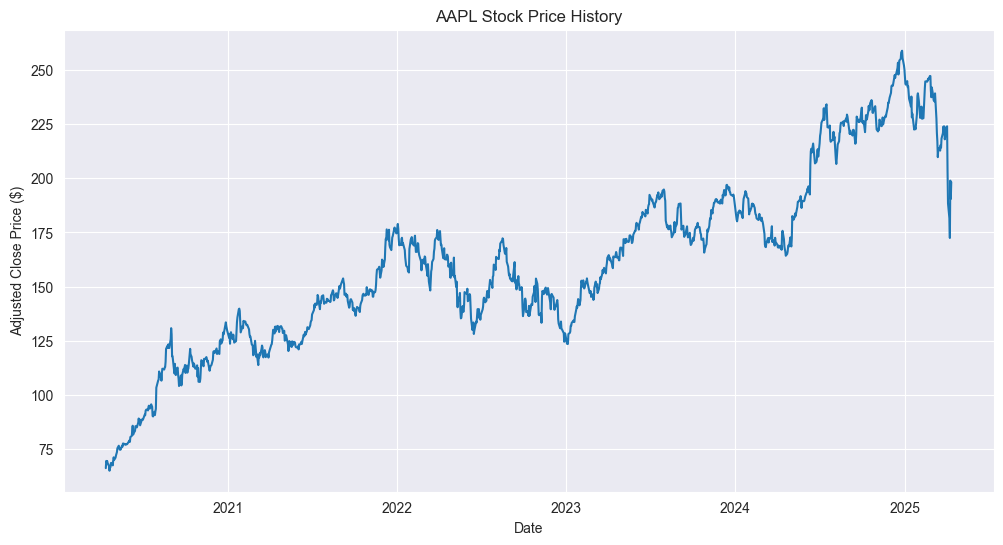

In [59]:
# Plot the price history
plt.figure(figsize=(12, 6))
plt.plot(apple_prices['date'], apple_prices['adj_close'])
plt.title('AAPL Stock Price History')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.grid(True)
plt.show()

/var/folders/m7/8zlp_5pn6dxbz1p19pwvxv3w0000gn/T/ipykernel_92595/1691809840.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x600 with 0 Axes>

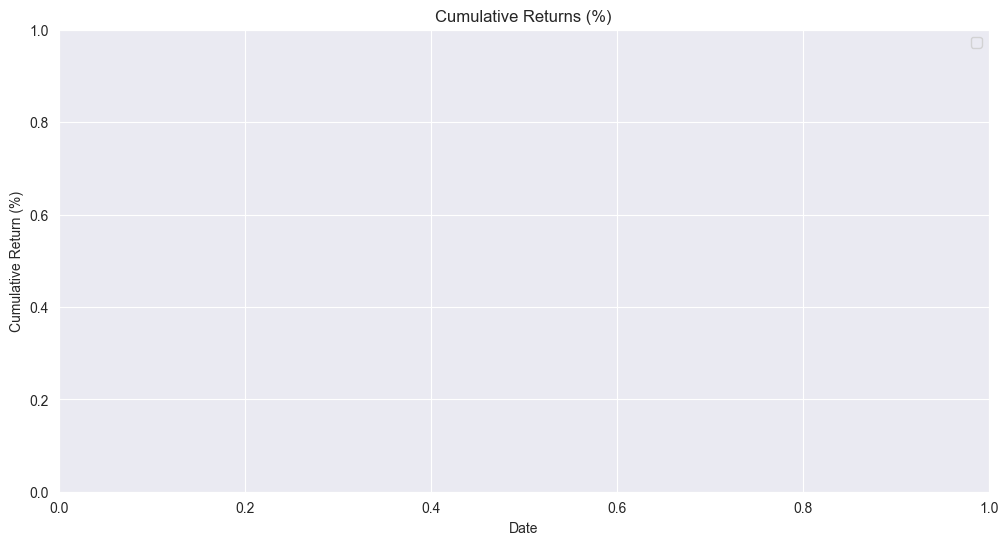

In [61]:
# Calculate and plot cumulative returns for all stocks
plt.figure(figsize=(12, 6))

# Check if 'ticker' column exists, if not try to get unique tickers another way
if 'ticker' in df_master.columns:
    tickers_to_plot = df_master['ticker'].drop_duplicates()#.tolist()
else:
    # If there's no ticker column, just use the tickers we imported earlier
    tickers_to_plot = tickers[:5]  # Use the first 5 tickers we imported

for ticker in tickers_to_plot:
    try:
        prices = df.get_price_history(ticker)
        if len(prices) > 0:
            # Calculate cumulative returns
            prices['daily_return'] = prices['adj_close'].pct_change()
            prices['cum_return'] = (1 + prices['daily_return']).cumprod()
            prices['cum_return'] = prices['cum_return'] / prices['cum_return'].iloc[0] * 100

            # Plot cumulative returns
            plt.plot(prices['date'], prices['cum_return'], label=ticker)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

plt.title('Cumulative Returns (%)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

Error determining tickers to plot: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Plotting the following tickers: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']


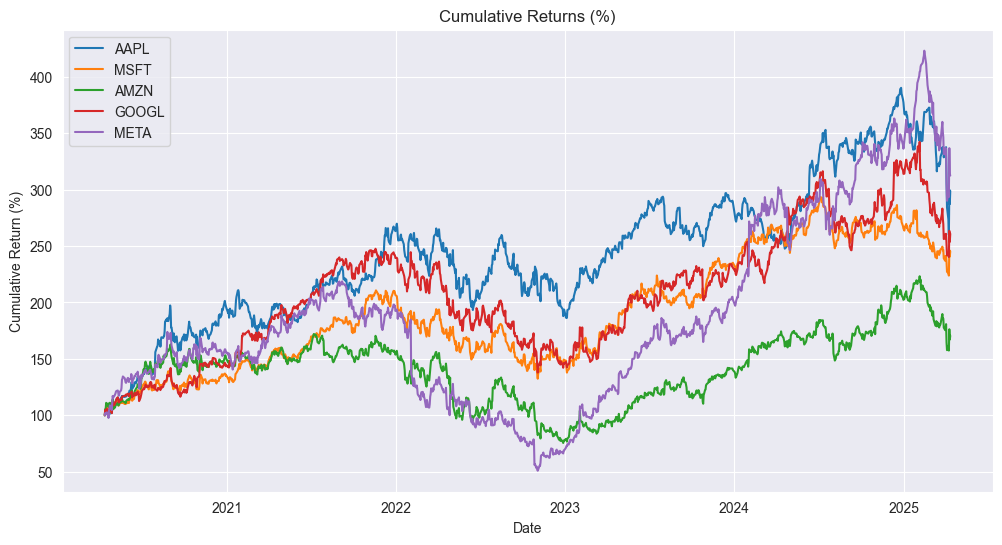

In [62]:
# Calculate and plot cumulative returns for all stocks
plt.figure(figsize=(12, 6))

# Safely determine tickers to plot with better error handling
try:
    if isinstance(df_master, pd.DataFrame) and 'ticker' in df_master.columns:
        # First check if df_master is a DataFrame and has 'ticker' column
        if df_master['ticker'].notnull().any():  # Check for non-null values
            tickers_to_plot = df_master.loc[df_master['ticker'].notnull(), 'ticker'].unique().tolist()
        else:
            print("Warning: 'ticker' column exists but contains only null values.")
            tickers_to_plot = tickers[:5]  # Fallback to imported tickers
    else:
        print("Using imported tickers as fallback since df_master lacks a valid 'ticker' column.")
        tickers_to_plot = tickers[:5]  # Use the first 5 tickers we imported
except Exception as e:
    print(f"Error determining tickers to plot: {e}")
    tickers_to_plot = tickers[:5]  # Fallback to imported tickers

print(f"Plotting the following tickers: {tickers_to_plot}")

for ticker in tickers_to_plot:
    try:
        prices = df.get_price_history(ticker)
        if len(prices) > 0:
            # Calculate cumulative returns
            prices['daily_return'] = prices['adj_close'].pct_change()
            # Handle NaN values that can occur from pct_change calculation
            prices['daily_return'] = prices['daily_return'].fillna(0)
            prices['cum_return'] = (1 + prices['daily_return']).cumprod()
            prices['cum_return'] = prices['cum_return'] / prices['cum_return'].iloc[0] * 100

            # Plot cumulative returns
            plt.plot(prices['date'], prices['cum_return'], label=ticker)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

plt.title('Cumulative Returns (%)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

<a id="ratios"></a>
## Financial ratios

In [63]:
# Get financial ratios for all stocks
financial_ratios = df.get_financial_ratios()

# Plot P/E ratios
plt.figure(figsize=(10, 6))
for ticker in df_master['ticker'].unique():
    try:
        ratios = financial_ratios[financial_ratios['ticker'] == ticker]
        if not ratios.empty:
            plt.bar(ticker, ratios['pe_ratio'].iloc[0])
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

plt.title('P/E Ratios by Stock')
plt.xlabel('Stock')
plt.ylabel('P/E Ratio')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'unique'

<a id="sector"></a>
## Sector analysis

In [64]:
# Group stocks by sector and calculate mean ratios
sector_analysis = df_master.groupby('sector').agg({
    'pe_ratio': 'mean',
    'forward_pe': 'mean',
    'price_to_book': 'mean',
    'price_to_sales': 'mean',
    'dividend_yield': 'mean',
    'beta': 'mean',
    'return_on_equity': 'mean',
    'debt_to_equity': 'mean'
}).round(2)

# Display sector analysis
sector_analysis

,pe_ratio,forward_pe,price_to_book,price_to_sales,dividend_yield,beta,return_on_equity,debt_to_equity
sector,,,,,,,,
Communication Services,21.15,19.51,6.72,NaN,0.45,1.16,0.35,17.95
Consumer Cyclical,33.43,30.06,6.85,NaN,NaN,1.39,0.24,54.34
Technology,31.40,24.91,27.09,NaN,0.68,1.13,0.85,89.50


/var/folders/m7/8zlp_5pn6dxbz1p19pwvxv3w0000gn/T/ipykernel_92595/1012825385.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(sector_analysis.index, rotation=45)
/var/folders/m7/8zlp_5pn6dxbz1p19pwvxv3w0000gn/T/ipykernel_92595/1012825385.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(sector_analysis.index, rotation=45)
/var/folders/m7/8zlp_5pn6dxbz1p19pwvxv3w0000gn/T/ipykernel_92595/1012825385.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(sector_analysis.index, rotation=45)
/var/folders/m7/8zlp_5pn6dxbz1p19pwvxv3w0000gn/T/ipykernel_92595/1012825385.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

<Figure size 1000x600 with 0 Axes>

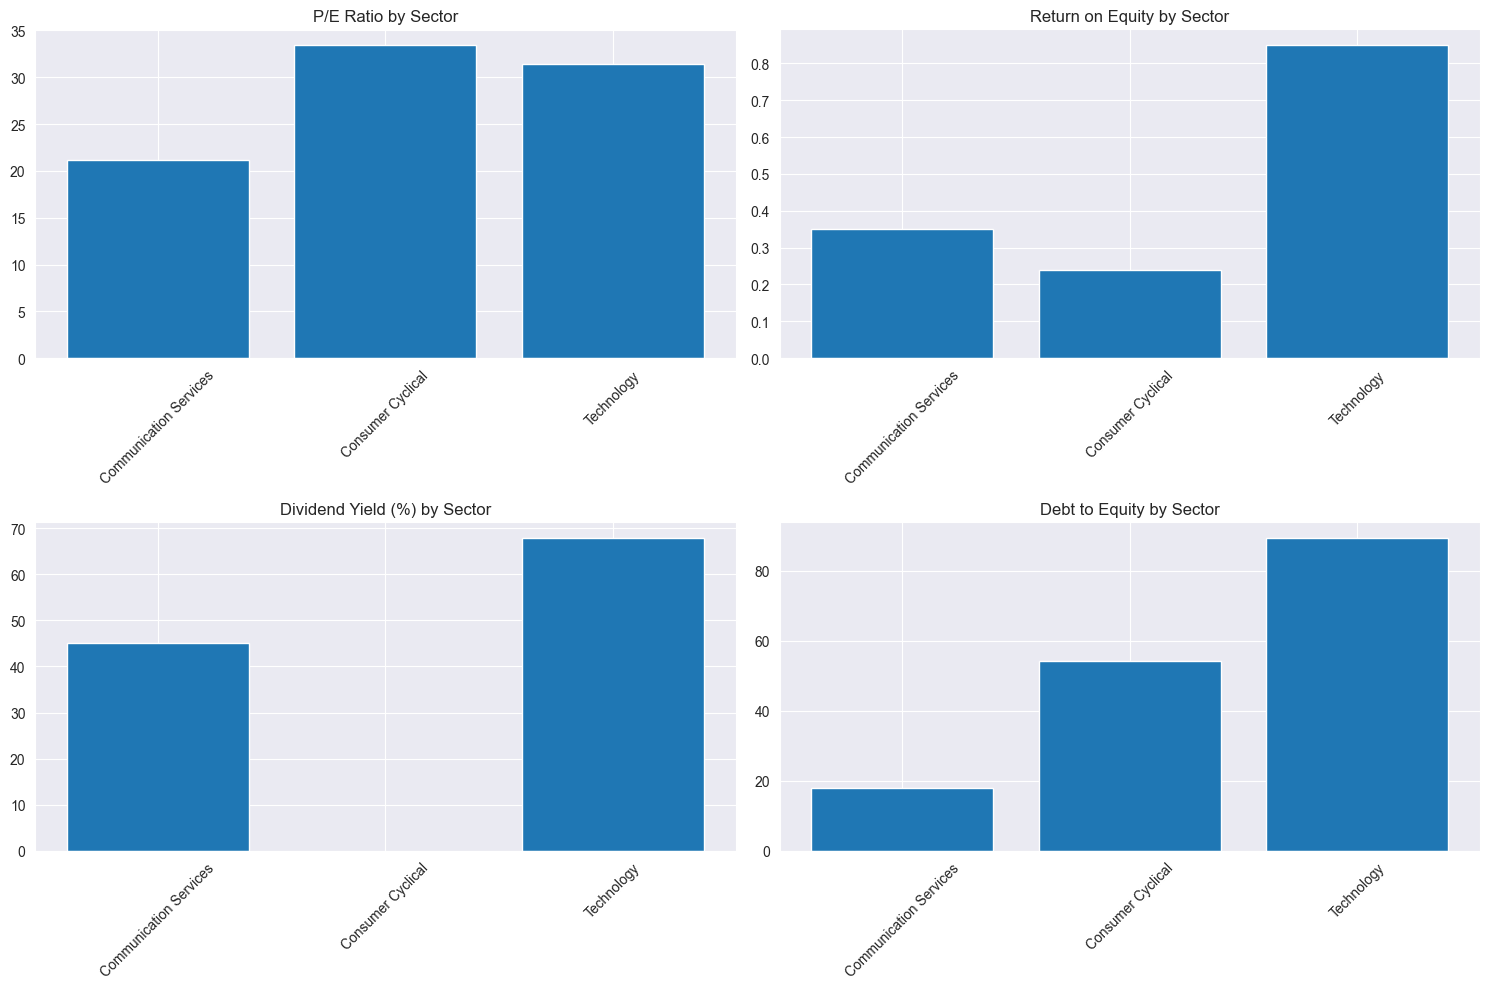

In [65]:
# Plot key metrics by sector
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# P/E Ratio
axes[0, 0].bar(sector_analysis.index, sector_analysis['pe_ratio'])
axes[0, 0].set_title('P/E Ratio by Sector')
axes[0, 0].set_xticklabels(sector_analysis.index, rotation=45)
axes[0, 0].grid(True, axis='y')

# Return on Equity
axes[0, 1].bar(sector_analysis.index, sector_analysis['return_on_equity'])
axes[0, 1].set_title('Return on Equity by Sector')
axes[0, 1].set_xticklabels(sector_analysis.index, rotation=45)
axes[0, 1].grid(True, axis='y')

# Dividend Yield
axes[1, 0].bar(sector_analysis.index, sector_analysis['dividend_yield'] * 100)
axes[1, 0].set_title('Dividend Yield (%) by Sector')
axes[1, 0].set_xticklabels(sector_analysis.index, rotation=45)
axes[1, 0].grid(True, axis='y')

# Debt to Equity
axes[1, 1].bar(sector_analysis.index, sector_analysis['debt_to_equity'])
axes[1, 1].set_title('Debt to Equity by Sector')
axes[1, 1].set_xticklabels(sector_analysis.index, rotation=45)
axes[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()

<a id="viz"></a>
# Visualizing the data
Let's create some more visualizations to better understand our financial data.

In [ ]:
# Create a correlation matrix of financial ratios
financial_metrics = ['pe_ratio', 'forward_pe', 'price_to_book', 'price_to_sales',
                     'dividend_yield', 'beta', 'profit_margins', 'debt_to_equity',
                     'return_on_equity', 'revenue_growth', 'earnings_growth']

# Filter out columns with all NaN values
valid_metrics = [col for col in financial_metrics if not df_master[col].isna().all()]

# Calculate correlation matrix
corr_matrix = df_master[valid_metrics].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(valid_metrics)), valid_metrics, rotation=90)
plt.yticks(range(len(valid_metrics)), valid_metrics)
plt.title('Correlation Matrix of Financial Metrics')

# Add correlation values
for i in range(len(valid_metrics)):
    for j in range(len(valid_metrics)):
        if not np.isnan(corr_matrix.iloc[i, j]):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center',
                     color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.show()

<a id="screening"></a>
# Screening stocks
Let's implement some screening criteria to find stocks that meet certain financial criteria.

In [ ]:
# Define screening functions
def screen_pe_ratio(df, max_pe=20):
    """Screen stocks with P/E ratio less than max_pe"""
    return df[(df['pe_ratio'] > 0) & (df['pe_ratio'] < max_pe)]

def screen_dividend_yield(df, min_yield=0.02):
    """Screen stocks with dividend yield greater than min_yield (e.g., 2%)"""
    return df[(df['dividend_yield'] > min_yield)]

def screen_growth(df, min_growth=0.1):
    """Screen stocks with revenue growth greater than min_growth (e.g., 10%)"""
    return df[(df['revenue_growth'] > min_growth)]

def screen_value(df, max_pe=15, min_roe=0.15):
    """Screen value stocks with low P/E and high ROE"""
    return df[(df['pe_ratio'] > 0) & (df['pe_ratio'] < max_pe) &
              (df['return_on_equity'] > min_roe)]

# Apply different screens
value_stocks = screen_value(df_master)
growth_stocks = screen_growth(df_master)
dividend_stocks = screen_dividend_yield(df_master)

# Display results
print("Value Stocks (P/E < 15, ROE > 15%):")
if not value_stocks.empty:
    print(value_stocks[['ticker', 'company', 'sector', 'pe_ratio', 'return_on_equity']])
else:
    print("No stocks found matching these criteria.")

print("\nGrowth Stocks (Revenue Growth > 10%):")
if not growth_stocks.empty:
    print(growth_stocks[['ticker', 'company', 'sector', 'revenue_growth']])
else:
    print("No stocks found matching these criteria.")

print("\nDividend Stocks (Dividend Yield > 2%):")
if not dividend_stocks.empty:
    print(dividend_stocks[['ticker', 'company', 'sector', 'dividend_yield']])
else:
    print("No stocks found matching these criteria.")

In [ ]:
# Create a more complex screener that combines multiple criteria
def custom_screener(df, criteria=None):
    """
    Screen stocks based on custom criteria

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing stock data
    criteria : dict
        Dictionary of criteria in the format {column: (operator, value)}
        Where operator is one of '<', '<=', '>', '>=', '==', '!='

    Returns
    -------
    pandas.DataFrame
        DataFrame containing filtered stocks
    """
    if criteria is None:
        return df

    filtered_df = df.copy()

    for column, (operator, value) in criteria.items():
        if column in filtered_df.columns:
            if operator == '<':
                filtered_df = filtered_df[filtered_df[column] < value]
            elif operator == '<=':
                filtered_df = filtered_df[filtered_df[column] <= value]
            elif operator == '>':
                filtered_df = filtered_df[filtered_df[column] > value]
            elif operator == '>=':
                filtered_df = filtered_df[filtered_df[column] >= value]
            elif operator == '==':
                filtered_df = filtered_df[filtered_df[column] == value]
            elif operator == '!=':
                filtered_df = filtered_df[filtered_df[column] != value]

    return filtered_df

# Define custom criteria
custom_criteria = {
    'pe_ratio': ('<', 20),
    'price_to_book': ('<', 3),
    'dividend_yield': ('>', 0.01),
    'debt_to_equity': ('<', 1.5),
    'return_on_equity': ('>', 0.1)
}

# Apply custom screener
custom_filtered = custom_screener(df_master, custom_criteria)

# Display results
print("Custom Screened Stocks:")
if not custom_filtered.empty:
    columns_to_display = ['ticker', 'company', 'sector', 'pe_ratio', 'price_to_book',
                          'dividend_yield', 'debt_to_equity', 'return_on_equity']
    available_columns = [col for col in columns_to_display if col in custom_filtered.columns]
    print(custom_filtered[available_columns])
else:
    print("No stocks found matching these criteria.")

In [ ]:
# Save the master DataFrame to a CSV file
df_master.to_csv('financial_data_master.csv', index=False)
print("Master data saved to 'financial_data_master.csv'")

# Additional clean-up
print("\nDatabase connection closed.")